In [1]:
import hashlib
import os
import tarfile
import zipfile
import requests

#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [2]:
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [3]:
def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

In [4]:
# 如果没有安装pandas，请取消下一行的注释
# !pip install pandas

%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [5]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [6]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [7]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [8]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [9]:
# 若无法获得测试数据，则可根据训练数据计算均值和标准差
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [10]:
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [11]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

In [12]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

In [13]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

In [14]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [15]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [22]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
#         if i == 0:
#             d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
#                      xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
#                      legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

折1，训练log rmse0.170061, 验证log rmse0.156109
折2，训练log rmse0.162132, 验证log rmse0.190998
折3，训练log rmse0.164032, 验证log rmse0.168492
折4，训练log rmse0.168475, 验证log rmse0.154768
折5，训练log rmse0.162973, 验证log rmse0.182651
5-折验证: 平均训练log rmse: 0.165535, 平均验证log rmse: 0.170604


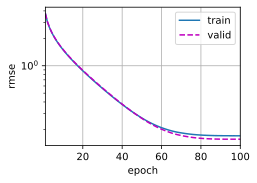

In [17]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

In [18]:
# 预测房价
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

In [ ]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

## 网格搜索 

折1，训练log rmse0.260982, 验证log rmse0.221836
折2，训练log rmse0.224835, 验证log rmse0.285688
折3，训练log rmse0.229812, 验证log rmse0.246063
折4，训练log rmse0.258318, 验证log rmse0.196664
折5，训练log rmse0.238711, 验证log rmse0.233916
lr 是 5, weight_decay 是 10, 5-折验证: 平均训练log rmse: 0.242532, 平均验证log rmse: 0.236834

折1，训练log rmse0.359523, 验证log rmse0.159590
折2，训练log rmse0.182481, 验证log rmse0.645269
折3，训练log rmse0.347139, 验证log rmse0.219426
折4，训练log rmse0.355023, 验证log rmse0.150298
折5，训练log rmse0.351873, 验证log rmse0.186473
lr 是 5, weight_decay 是 1, 5-折验证: 平均训练log rmse: 0.319208, 平均验证log rmse: 0.272211

折1，训练log rmse0.125814, 验证log rmse0.151829
折2，训练log rmse0.121202, 验证log rmse0.151939
折3，训练log rmse0.122348, 验证log rmse0.150823
折4，训练log rmse0.126873, 验证log rmse0.136698
折5，训练log rmse0.118054, 验证log rmse0.162494
lr 是 5, weight_decay 是 0, 5-折验证: 平均训练log rmse: 0.122858, 平均验证log rmse: 0.150757

折1，训练log rmse0.138774, 验证log rmse0.143209
折2，训练log rmse0.132209, 验证log rmse0.164839
折3，训练log rmse0.132327, 验证log rmse0.156466


折1，训练log rmse3.741001, 验证log rmse3.755555
折2，训练log rmse3.741210, 验证log rmse3.751751
折3，训练log rmse3.740043, 验证log rmse3.755202
折4，训练log rmse3.749102, 验证log rmse3.724873
折5，训练log rmse3.742548, 验证log rmse3.745671
lr 是 0.01, weight_decay 是 0.01, 5-折验证: 平均训练log rmse: 3.742781, 平均验证log rmse: 3.746610

折1，训练log rmse3.741050, 验证log rmse3.755536
折2，训练log rmse3.741237, 验证log rmse3.751771
折3，训练log rmse3.739973, 验证log rmse3.755129
折4，训练log rmse3.749084, 验证log rmse3.724855
折5，训练log rmse3.742712, 验证log rmse3.745826
lr 是 0.01, weight_decay 是 0.001, 5-折验证: 平均训练log rmse: 3.742811, 平均验证log rmse: 3.746624

折1，训练log rmse6.039910, 验证log rmse6.054844
折2，训练log rmse6.040345, 验证log rmse6.050566
折3，训练log rmse6.039025, 验证log rmse6.054101
折4，训练log rmse6.048141, 验证log rmse6.024024
折5，训练log rmse6.041361, 验证log rmse6.044202
lr 是 0.001, weight_decay 是 10, 5-折验证: 平均训练log rmse: 6.041757, 平均验证log rmse: 6.045547

折1，训练log rmse6.039117, 验证log rmse6.054107
折2，训练log rmse6.040671, 验证log rmse6.050731
折3，训练log rmse6.038359, 验证

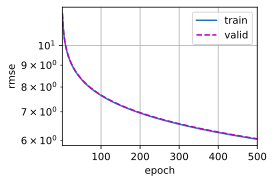

In [21]:
num_epochs = 500
lr_s = [5, 1, 0.1, 0.01, 0.01, 0.001]
weight_decay_s = [10, 1, 0, 0.1, 0.01, 0.001]
for lr in lr_s:
    #print('lr is', lr)
    for weight_decay in weight_decay_s:
        #print('weight_decay is', weight_decay)
        train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                                  weight_decay, batch_size)
        print(f'lr 是 {lr}, weight_decay 是 {weight_decay}, {k}-折验证: 平均训练log rmse: {float(train_l):f}, '
              f'平均验证log rmse: {float(valid_l):f}')
        print()

In [23]:
num_epochs = 1000
lr_s = [5.3, 5.2, 5.1, 5, 4.9, 4.8]
weight_decay_s = [0, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
for lr in lr_s:
    #print('lr is', lr)
    for weight_decay in weight_decay_s:
        #print('weight_decay is', weight_decay)
        train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                                  weight_decay, batch_size)
        print(f'lr 是 {lr}, weight_decay 是 {weight_decay}, {k}-折验证: 平均训练log rmse: {float(train_l):f}, '
              f'平均验证log rmse: {float(valid_l):f}')
        print()

折1，训练log rmse0.125221, 验证log rmse0.177592
折2，训练log rmse0.117896, 验证log rmse0.175382
折3，训练log rmse0.119344, 验证log rmse0.161515
折4，训练log rmse0.124572, 验证log rmse0.157312
折5，训练log rmse0.112401, 验证log rmse0.163588
lr 是 5.3, weight_decay 是 0, 5-折验证: 平均训练log rmse: 0.119887, 平均验证log rmse: 0.167078

折1，训练log rmse0.125207, 验证log rmse0.177282
折2，训练log rmse0.117737, 验证log rmse0.174212
折3，训练log rmse0.119776, 验证log rmse0.162007
折4，训练log rmse0.124671, 验证log rmse0.156909
折5，训练log rmse0.112457, 验证log rmse0.163826
lr 是 5.3, weight_decay 是 0.0001, 5-折验证: 平均训练log rmse: 0.119970, 平均验证log rmse: 0.166847

折1，训练log rmse0.125354, 验证log rmse0.175322
折2，训练log rmse0.117500, 验证log rmse0.171487
折3，训练log rmse0.120105, 验证log rmse0.161687
折4，训练log rmse0.124953, 验证log rmse0.154196
折5，训练log rmse0.112334, 验证log rmse0.162824
lr 是 5.3, weight_decay 是 0.0005, 5-折验证: 平均训练log rmse: 0.120049, 平均验证log rmse: 0.165103

折1，训练log rmse0.125499, 验证log rmse0.172847
折2，训练log rmse0.117917, 验证log rmse0.169806
折3，训练log rmse0.119764, 验证lo

折1，训练log rmse0.125302, 验证log rmse0.173838
折2，训练log rmse0.117932, 验证log rmse0.172832
折3，训练log rmse0.119823, 验证log rmse0.161012
折4，训练log rmse0.124736, 验证log rmse0.155624
折5，训练log rmse0.112572, 验证log rmse0.163260
lr 是 5, weight_decay 是 0.0001, 5-折验证: 平均训练log rmse: 0.120073, 平均验证log rmse: 0.165313

折1，训练log rmse0.125388, 验证log rmse0.173760
折2，训练log rmse0.118044, 验证log rmse0.170773
折3，训练log rmse0.119807, 验证log rmse0.160428
折4，训练log rmse0.124890, 验证log rmse0.153249
折5，训练log rmse0.112950, 验证log rmse0.163041
lr 是 5, weight_decay 是 0.0005, 5-折验证: 平均训练log rmse: 0.120216, 平均验证log rmse: 0.164250

折1，训练log rmse0.126007, 验证log rmse0.172376
折2，训练log rmse0.117886, 验证log rmse0.168732
折3，训练log rmse0.120000, 验证log rmse0.160157
折4，训练log rmse0.125155, 验证log rmse0.150380
折5，训练log rmse0.113514, 验证log rmse0.162994
lr 是 5, weight_decay 是 0.001, 5-折验证: 平均训练log rmse: 0.120512, 平均验证log rmse: 0.162928

折1，训练log rmse0.126732, 验证log rmse0.163532
折2，训练log rmse0.119103, 验证log rmse0.161554
折3，训练log rmse0.121235, 验证log 